In [33]:
import pandas as pd
import yfinance as yf
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

def scatterplot_matrix(data, names, **kwargs):
    """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid."""
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numdata, ncols=numdata, figsize=(15,15))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].plot(data.iloc[:,x], data.iloc[:,y], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    # for i, j in zip(range(numdata), itertools.cycle((-1, 0))):
    #     print(i, j)
    #     axes[j,i].xaxis.set_visible(True)
    #     axes[i,j].yaxis.set_visible(True)

    return fig   


## Theory and intuition about copulas can be found in Attilio's Meucci paper ["A short, comprehensive, practical guide to copulas"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1847864)

[*********************100%***********************]  5 of 5 completed


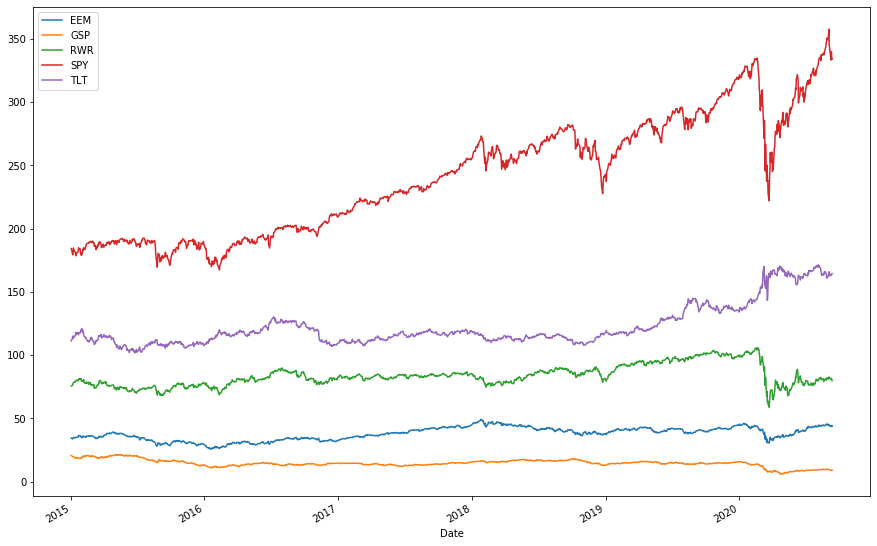

In [34]:
# SPY: S&P
# EEM: Emerging markets basket
# TLT: 20+ year treasury bond
# GSP: S&P GSCI (commodities market)
# RWR: Dow Jones REITs (real state)

tickers_list = ['SPY', 'EEM', 'TLT', 'GSP', 'RWR']
df = yf.download(tickers_list,'2015-1-1')['Adj Close']
df.plot(figsize=(15,10))

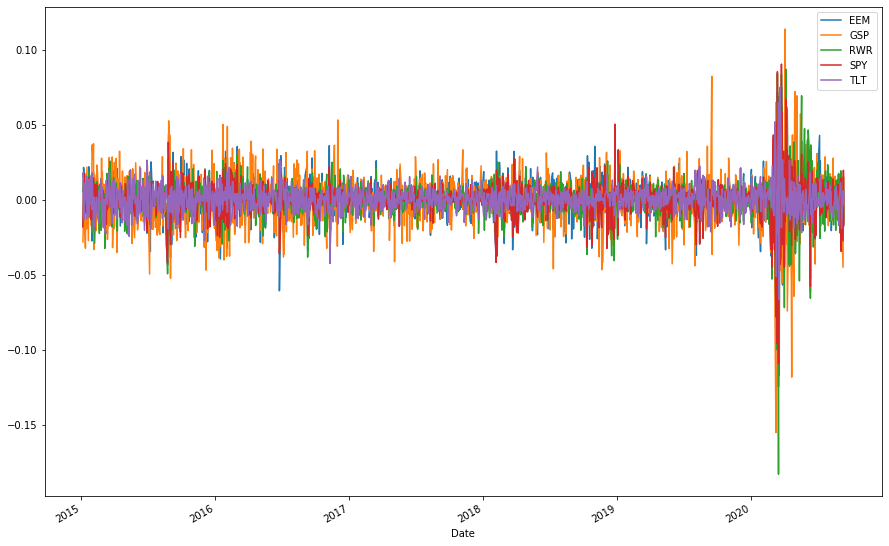

In [5]:
daily_returns_df = df.pct_change(1).dropna()
daily_returns_df.plot(figsize=(15,10))

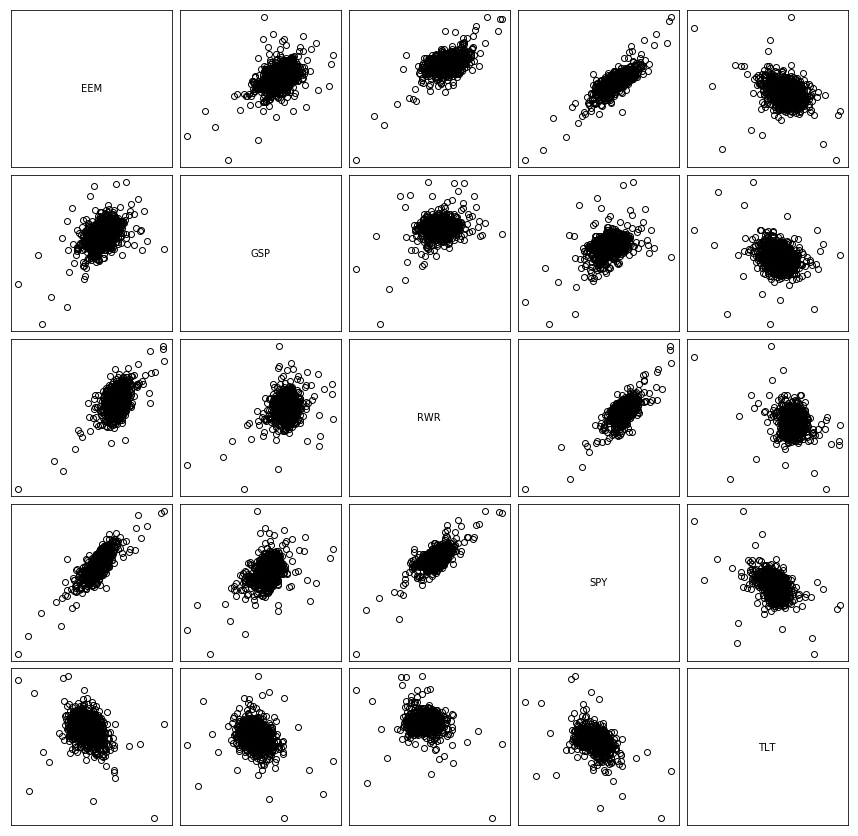

In [6]:
fig = scatterplot_matrix(daily_returns_df, list(daily_returns_df.columns), linestyle='none', marker='o', color='black', mfc='none')
# fig.suptitle('Simple Scatterplot Matrix')

## 1. Example with known multivariate normal distribution

In [7]:
mvnorm = st.multivariate_normal(mean=[0, 0], cov=[[1., 0.5], 
                                                     [0.5, 1.]])
x = mvnorm.rvs(10000)

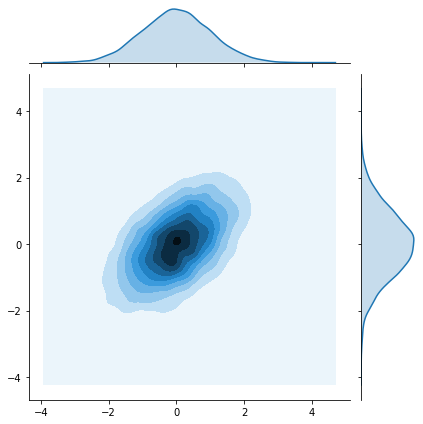

In [8]:
sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None)

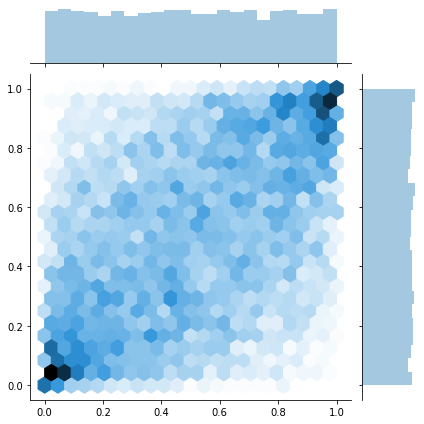

In [9]:
x_unif = st.norm.cdf(x)
sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)

### Fitting a gaussian copula

In [10]:
from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()
copula.fit(x)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


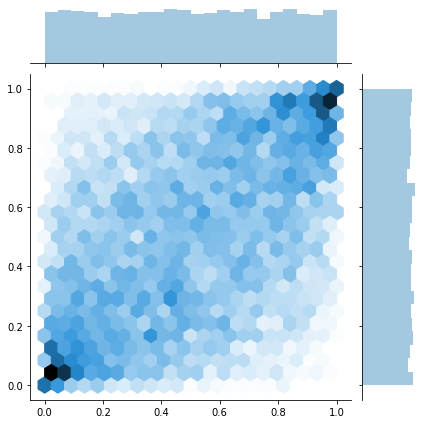

In [11]:
x1 = copula.univariates[0].cdf(x[:,0])
x2 = copula.univariates[1].cdf(x[:,1])
sns.jointplot(x1, x2, kind='hex', stat_func=None)

### Generate samples from the fitted copula 

In [12]:
from copulas.visualization import compare_2d

synthetic = copula.sample(len(x))
synthetic

,0,1
0,-0.106055,0.480187
1,-1.249893,-0.972528
2,-0.761947,0.089055
3,2.190921,1.165840
4,-0.449511,-0.313950
...,...,...
9995,-1.210070,-1.051072
9996,0.878557,0.071863
9997,0.067589,-0.217192
9998,0.944088,1.301406


## 2. Real data experiment using [Copulas](https://sdv.dev/Copulas/index.html) package

An alternative package is [Copulae](https://copulae.readthedocs.io/en/latest/).

In [13]:
copula = GaussianMultivariate()
copula.fit(daily_returns_df)

marginal_cdfs = {}
for i, j in enumerate(daily_returns_df.columns):
    marginal = copula.univariates[i].cdf(daily_returns_df.iloc[:,i])
    marginal_cdfs[j] = marginal
marginal_cdfs_df = pd.DataFrame.from_dict(marginal_cdfs)
marginal_cdfs_df

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
C:\ProgramData\Anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale


,EEM,GSP,RWR,SPY,TLT
0,0.067511,0.043258,0.709174,0.033494,0.968416
1,0.324975,0.089643,0.838604,0.093902,0.980080
2,0.949423,0.487408,0.923385,0.921505,0.373968
3,0.912867,0.612909,0.614639,0.958562,0.055862
4,0.355056,0.195803,0.535662,0.115936,0.912547
...,...,...,...,...,...
1427,0.058318,0.263653,0.191042,0.010027,0.622828
1428,0.491184,0.160583,0.506846,0.113265,0.014044
1429,0.071068,0.012141,0.068581,0.015643,0.776802
1430,0.887550,0.869561,0.765563,0.966235,0.341633


In [14]:
copula.covariance

array([[ 1.00045367,  0.4266654 ,  0.44898028,  0.77212645, -0.28814772],
       [ 0.4266654 ,  1.00054837,  0.164935  ,  0.39240635, -0.24438238],
       [ 0.44898028,  0.164935  ,  0.99960639,  0.5919157 , -0.05071769],
       [ 0.77212645,  0.39240635,  0.5919157 ,  0.99952344, -0.37900128],
       [-0.28814772, -0.24438238, -0.05071769, -0.37900128,  0.94288336]])

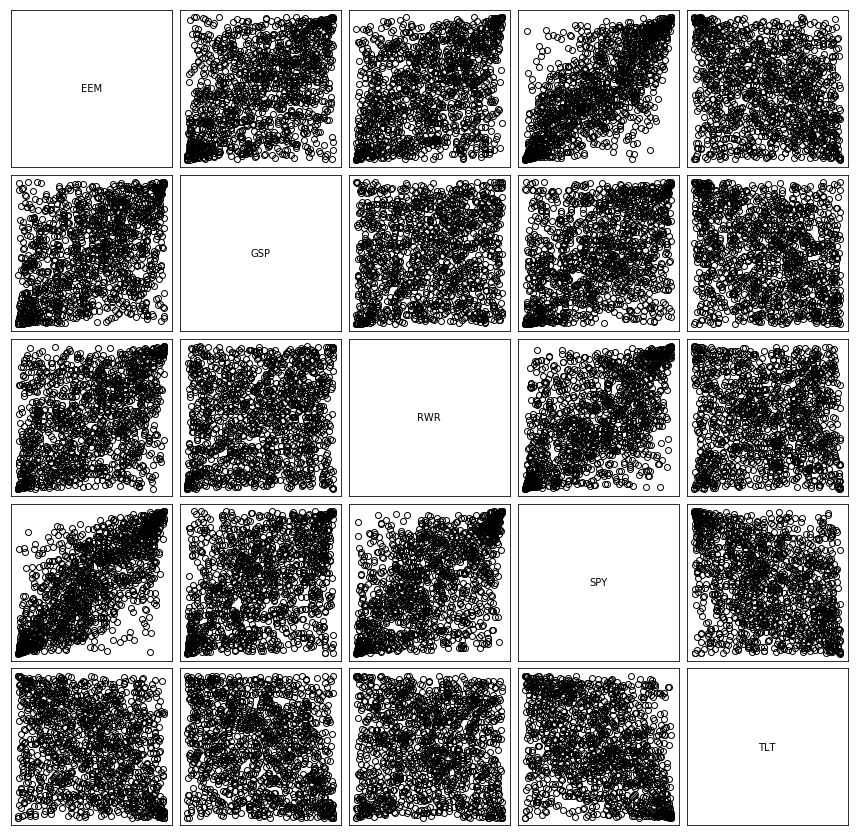

In [15]:
fig = scatterplot_matrix(marginal_cdfs_df, list(daily_returns_df.columns), linestyle='none', marker='o', color='black', mfc='none')

### Here i have assumed a Gaussian copula. Discussions on how to fit the best copula function to your marginals can be found [here](https://copulae.readthedocs.io/en/latest/) and [here](http://www.deep-mind.org/2017/09/24/empirical_copula/)

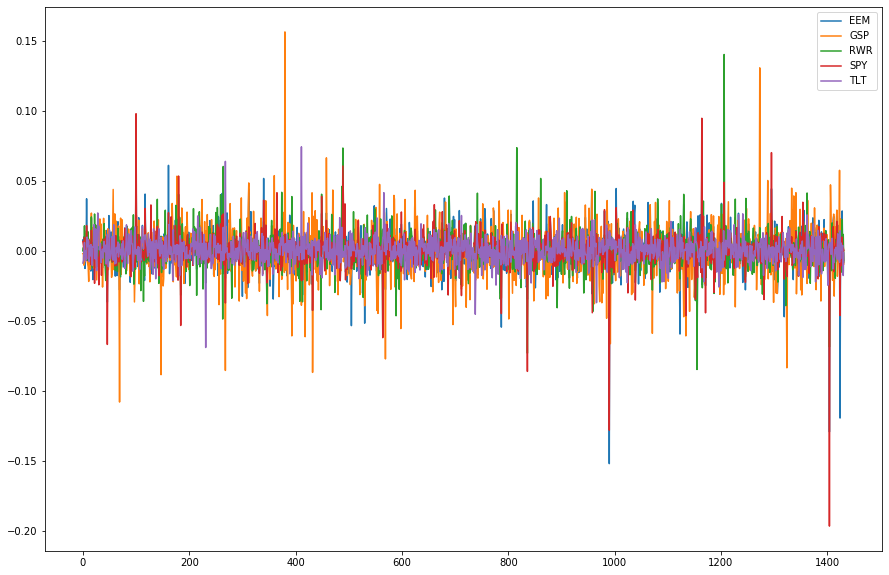

In [16]:
synthetic = copula.sample(len(marginal_cdfs_df))
synthetic.plot(figsize=(15,10))

### Copula implied marginal vs empirical distribution

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1742: UserWarning: tight_layout : falling back to Agg renderer
  f.tight_layout()


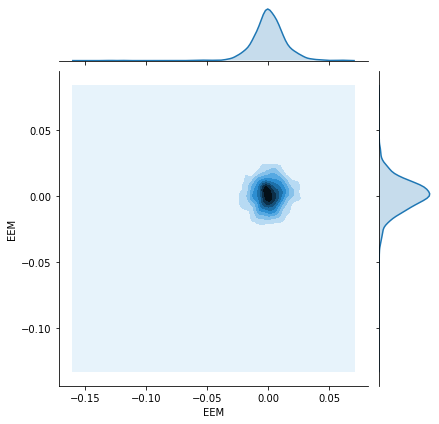

In [17]:
sns.jointplot(synthetic.iloc[:,0], daily_returns_df.iloc[:, 0], kind='kde', stat_func=None)

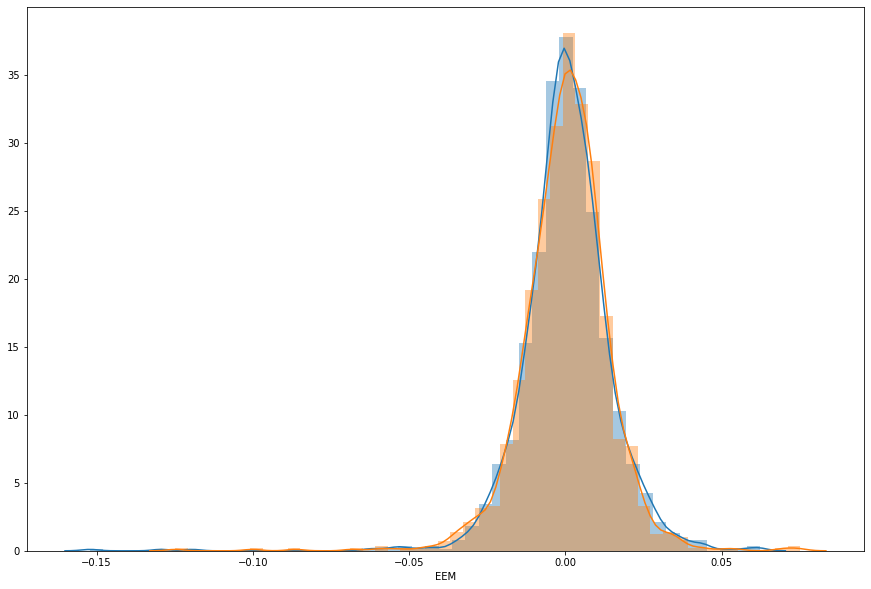

In [29]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(synthetic.iloc[:,0], ax=ax)
sns.distplot(daily_returns_df.iloc[:, 0], ax=ax)

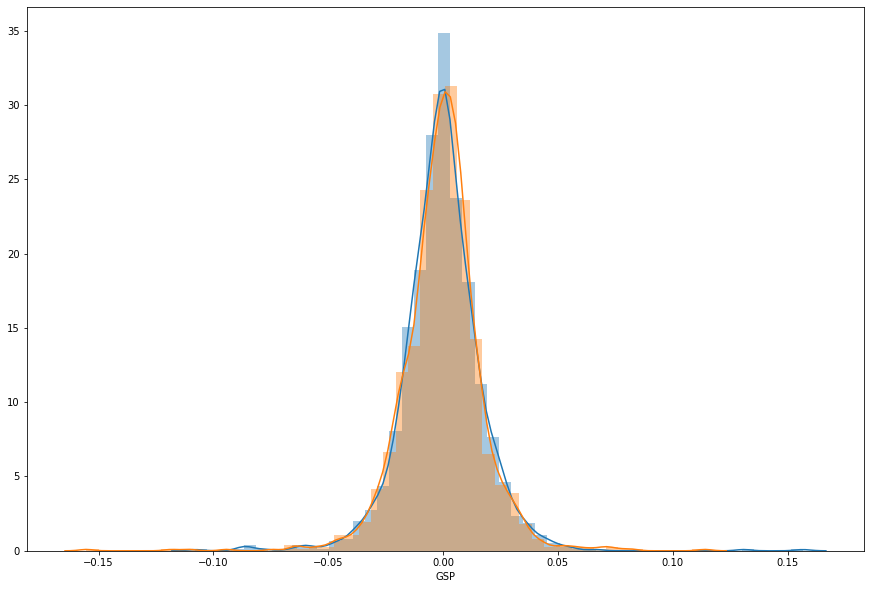

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(synthetic.iloc[:,1], ax=ax)
sns.distplot(daily_returns_df.iloc[:, 1], ax=ax)

## 3. Risk metrics using copulas 

[Krokhmal et. al. 2001, *Portfolio Optimization with Conditional Value-at-Risk Objective and Constraints*](https://www.ise.ufl.edu/uryasev/files/2011/11/kro_CVaR.pdf)

### Compute Copula Value-at-risk and Expected Shortfall (CVaR) of a equal weight portfolio

In [231]:
weights = [1/len(synthetic.columns) for i in range(0, len(synthetic.columns))]
portfolio_returns_df = synthetic * weights
portfolio_returns_df['portfolio_ret'] = portfolio_returns_df.sum(axis=1)

synthetic.quantile(0.1) * 100


EEM   -1.432798
GSP   -2.062673
RWR   -1.252689
SPY   -0.866269
TLT   -0.956713
Name: 0.1, dtype: float64

In [227]:
copula_portfolio_VaR = portfolio_returns_df.quantile(0.1)['portfolio_ret']
copula_portfolio_CVaR = np.mean(portfolio_returns_df['portfolio_ret'][portfolio_returns_df['portfolio_ret'] < - copula_portfolio_VaR])
print('Portfolio copula VaR', copula_portfolio_VaR * 100, 'CVaR', copula_portfolio_CVaR * 100)

Portfolio copula VaR -0.8941319609805863 CVaR -0.15748372453594825


### Compute Value-at-risk and Expected Shortfall (CVaR) of a equal weight portfolio assuming normal returns

In [233]:
covariance = daily_returns_df.cov()
mean_vec = daily_returns_df.mean(axis=0)
norm_synthetic = pd.DataFrame(st.multivariate_normal.rvs(mean_vec, covariance, size=100))
portfolio_norm_returns_df = norm_synthetic * weights
portfolio_norm_returns_df['portfolio_ret'] = portfolio_norm_returns_df.sum(axis=1)

norm_portfolio_VaR = portfolio_norm_returns_df.quantile(0.1)['portfolio_ret']
norm_portfolio_CVaR = np.mean(portfolio_norm_returns_df['portfolio_ret'][portfolio_norm_returns_df['portfolio_ret'] < - norm_portfolio_VaR])
print('Portfolio normal VaR', norm_portfolio_VaR * 100, 'CVaR', norm_portfolio_CVaR * 100)

Portfolio normal VaR -0.9805772599454237 CVaR -0.19179977787373453


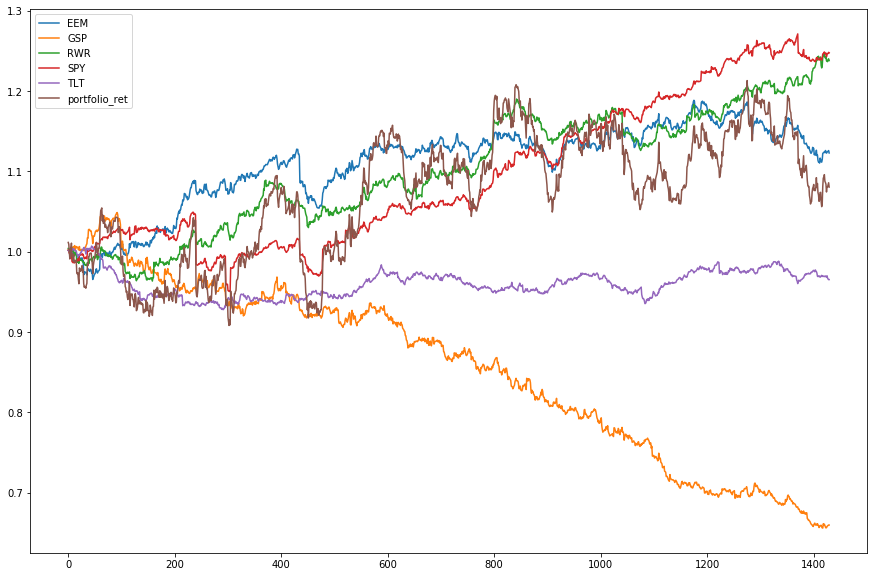

In [225]:
np.cumprod(1 + portfolio_returns_df).plot(figsize=(15, 10))

## 4. Portfolio optimization using copulas 


### Portfolio optimization can be done using the [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html) package.